In [1]:
%pip install -e ..

Obtaining file:///home/borges/dev/research/anomaly-detection-c2beaconing-fl
  Installing build dependencies ... -done
  Checking if build backend supports build_editable ... one
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Getting requirements to build editable ... -done
  Preparing editable metadata (pyproject.toml) ... one
  Preparing editable metadata (pyproject.toml) ... -done
done
  Building editable for anomaly-detection-c2beaconing-fl (pyproject.toml) ... Building wheels for collected packages: anomaly-detection-c2beaconing-fl
  Building editable for anomaly-detection-c2beaconing-fl (pyproject.toml) ... -done
  Created wheel for anomaly-detection-c2beaconing-fl: filename=anomaly_detection_c2beaconing_fl-0.1.0-0.editable-py3-none-any.whl size=2643 sha256=aac555d4cfabae17825d54a84761249702a0d36849ab50ec4f36250250909559
  Stored in directory: /tmp/pip-ephem-wheel-cache-3mz92toh/wheels/79/d8/50/15984c7fa55f2cf5e668

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
DATASET_PATH = os.getenv("CTU_PATH")

## CTU-13 Dataset Overview
- **Source:** [Stratosphere Laboratory – CTU-13 Dataset](https://www.stratosphereips.org/datasets-ctu13/)
- **Summary:** Thirteen labeled scenarios capturing real botnet traffic mixed with normal and background activity, recorded at CTU University in 2011.
- **Artifacts:** Each scenario provides botnet-only pcaps, bidirectional NetFlow files with detailed labels, and the original malware sample.
- **Recommended usage:** The maintainers advise using the bidirectional NetFlows for analysis due to richer context and improved labeling.
- **Citation:** Sebastian Garcia, Martin Grill, Jan Stiborek, Alejandro Zunino. *An empirical comparison of botnet detection methods*. Computers & Security, 45, 100–123, 2014.

In [4]:
raw_df = pd.read_csv(DATASET_PATH)

In [5]:
raw_df.describe()

,Dur,sTos,dTos,TotPkts,TotBytes,SrcBytes
count,2.824636e+06,2.814046e+06,2.629446e+06,2.824636e+06,2.824636e+06,2.824636e+06
mean,4.322060e+02,2.786664e-02,4.430591e-04,2.547990e+01,1.929134e+04,4.155290e+03
std,9.958423e+02,2.220372e+00,3.332693e-02,3.124788e+03,3.212186e+06,1.858530e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00
25%,3.130000e-04,0.000000e+00,0.000000e+00,2.000000e+00,2.140000e+02,7.800000e+01
50%,1.194000e-03,0.000000e+00,0.000000e+00,2.000000e+00,2.610000e+02,8.300000e+01
75%,9.012607e+00,0.000000e+00,0.000000e+00,4.000000e+00,5.880000e+02,2.610000e+02
max,3.600031e+03,1.920000e+02,3.000000e+00,2.686731e+06,2.689640e+09,2.635366e+09


In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2824636 entries, 0 to 2824635
Data columns (total 15 columns):
 #   Column     Dtype  
---  ------     -----  
 0   StartTime  object 
 1   Dur        float64
 2   Proto      object 
 3   SrcAddr    object 
 4   Sport      object 
 5   Dir        object 
 6   DstAddr    object 
 7   Dport      object 
 8   State      object 
 9   sTos       float64
 10  dTos       float64
 11  TotPkts    int64  
 12  TotBytes   int64  
 13  SrcBytes   int64  
 14  Label      object 
dtypes: float64(3), int64(3), object(9)
memory usage: 323.3+ MB


In [7]:
def convert_port(port):
    """Convert port to integer, handling hex and missing values"""
    if pd.isna(port) or port == '-':
        return None
    try:
        # Check if it's hex format (0x...)
        if isinstance(port, str) and port.startswith('0x'):
            return int(port, 16)
        return int(port)
    except (ValueError, TypeError):
        return None

In [8]:
df = raw_df.copy()

df['StartTime'] = pd.to_datetime(df['StartTime'])

# Convert ports to integer (handling non-numeric values)
# Ports might have values like '0x0050' (hex) or '-' for missing

df['Sport'] = df['Sport'].apply(convert_port)
df['Dport'] = df['Dport'].apply(convert_port)

# Convert ToS values to integers (they might be hex or float)
df['sTos'] = df['sTos'].fillna(0).astype('int32')
df['dTos'] = df['dTos'].fillna(0).astype('int32')

# Convert categorical columns to category dtype for memory efficiency
categorical_columns = ['Proto', 'Dir', 'State', 'Label']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Keep numeric columns as they are (already appropriate types)
# TotPkts, TotBytes, SrcBytes are already int64

print("Data types after conversion:")
print("=" * 80)
df.info()
print("\n" + "=" * 80)
print(f"Memory usage reduced from {raw_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB to {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2824636 entries, 0 to 2824635
Data columns (total 15 columns):
 #   Column     Dtype         
---  ------     -----         
 0   StartTime  datetime64[ns]
 1   Dur        float64       
 2   Proto      category      
 3   SrcAddr    object        
 4   Sport      float64       
 5   Dir        category      
 6   DstAddr    object        
 7   Dport      float64       
 8   State      category      
 9   sTos       int32         
 10  dTos       int32         
 11  TotPkts    int64         
 12  TotBytes   int64         
 13  SrcBytes   int64         
 14  Label      category      
dtypes: category(4), datetime64[ns](1), float64(3), int32(2), int64(3), object(2)
memory usage: 229.0+ MB

Memory usage reduced from 1598.30 MB to 517.35 MB
Memory usage reduced from 1598.30 MB to 517.35 MB


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

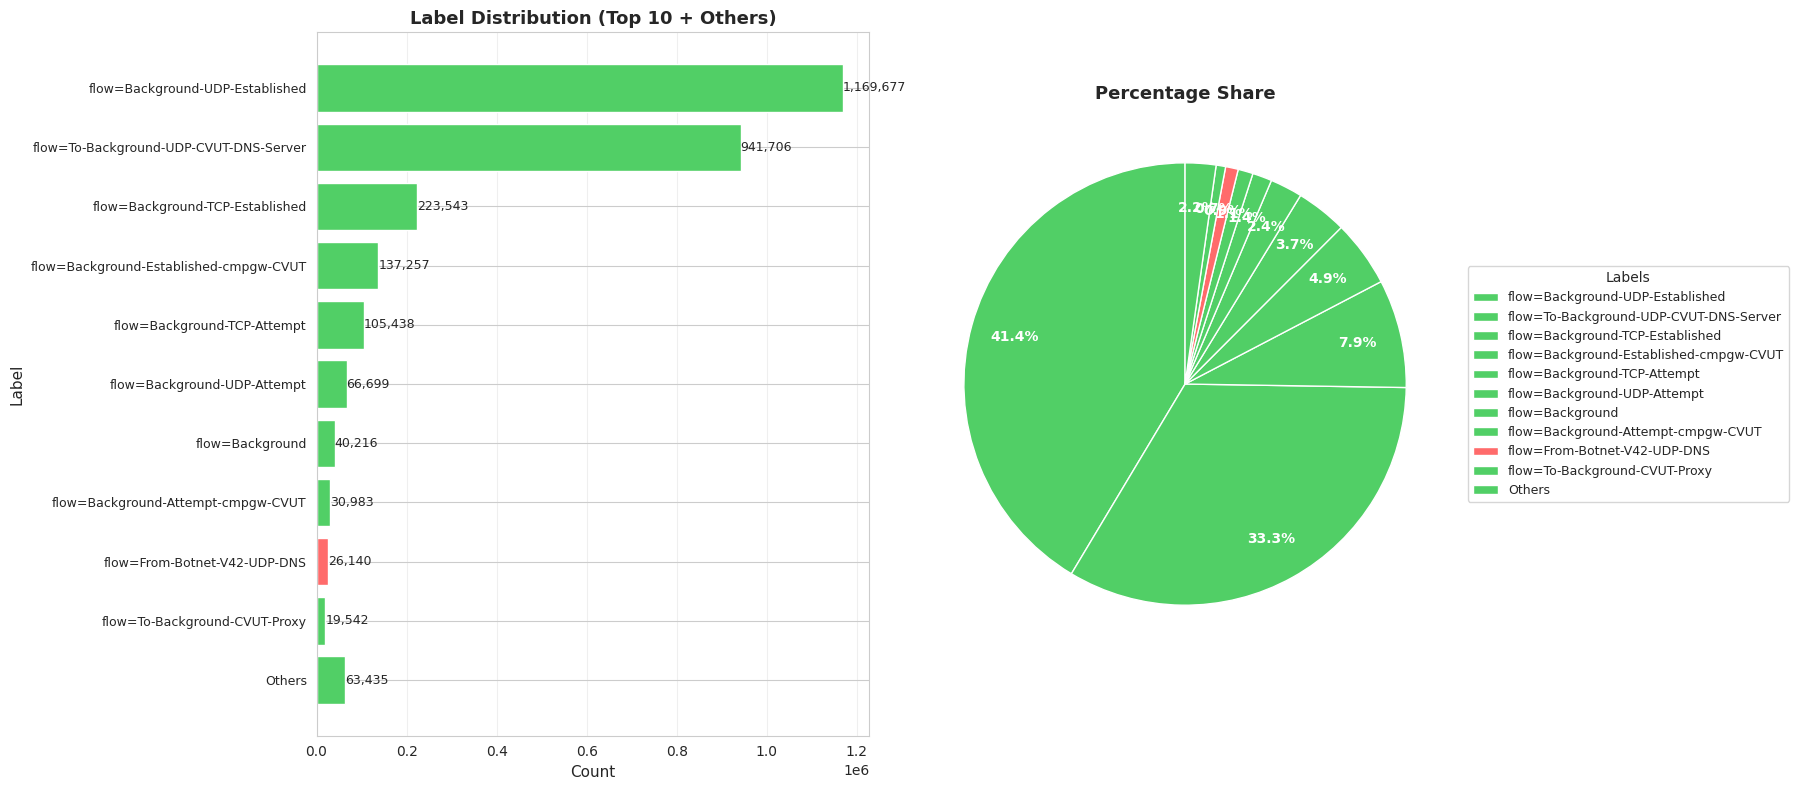


📊 Label Statistics (Top entries):
Label                                                     Count   Percentage
--------------------------------------------------------------------------------
flow=Background-UDP-Established                       1,169,677       41.41%
flow=To-Background-UDP-CVUT-DNS-Server                  941,706       33.34%
flow=Background-TCP-Established                         223,543        7.91%
flow=Background-Established-cmpgw-CVUT                  137,257        4.86%
flow=Background-TCP-Attempt                             105,438        3.73%
flow=Background-UDP-Attempt                              66,699        2.36%
flow=Background                                          40,216        1.42%
flow=Background-Attempt-cmpgw-CVUT                       30,983        1.10%
flow=From-Botnet-V42-UDP-DNS                             26,140        0.93%
flow=To-Background-CVUT-Proxy                            19,542        0.69%
Others                               

In [10]:
top_n = 10
label_counts = df['Label'].value_counts()

top_labels = label_counts.head(top_n)
others_count = label_counts.iloc[top_n:].sum()

plot_counts = top_labels.copy()
if others_count > 0:
    plot_counts = pd.concat([plot_counts, pd.Series({'Others': others_count})])

label_pct = (plot_counts / len(df) * 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

colors = ['#ff6b6b' if 'Botnet' in str(label) else '#51cf66' for label in plot_counts.index]
bars1 = ax1.barh(range(len(plot_counts)), plot_counts.values, color=colors)
ax1.set_yticks(range(len(plot_counts)))
ax1.set_yticklabels(plot_counts.index, fontsize=9)
ax1.set_xlabel('Count', fontsize=11)
ax1.set_ylabel('Label', fontsize=11)
ax1.set_title(f'Label Distribution (Top {top_n} + Others)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

for bar, count in zip(bars1, plot_counts.values):
    ax1.text(count, bar.get_y() + bar.get_height() / 2,
             f'{count:,.0f}', va='center', fontsize=9)

wedges, _, autotexts = ax2.pie(plot_counts.values,
                               labels=None,
                               autopct='%1.1f%%',
                               colors=colors,
                               startangle=90,
                               pctdistance=0.8)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

ax2.legend(wedges, plot_counts.index,
           title='Labels',
           loc='center left',
           bbox_to_anchor=(1, 0, 0.5, 1),
           fontsize=9)
ax2.set_title('Percentage Share', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Label Statistics (Top entries):")
print("=" * 80)
print(f"{'Label':<50s} {'Count':>12s} {'Percentage':>12s}")
print("-" * 80)
for label, count in plot_counts.items():
    print(f"{label:<50s} {count:>12,} {count / len(df) * 100:>11.2f}%")
print("=" * 80)
print(f"{'TOTAL (Top + Others)':<50s} {plot_counts.sum():>12,} {plot_counts.sum() / len(df) * 100:>11.2f}%")

/tmp/ipykernel_18643/3372590602.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


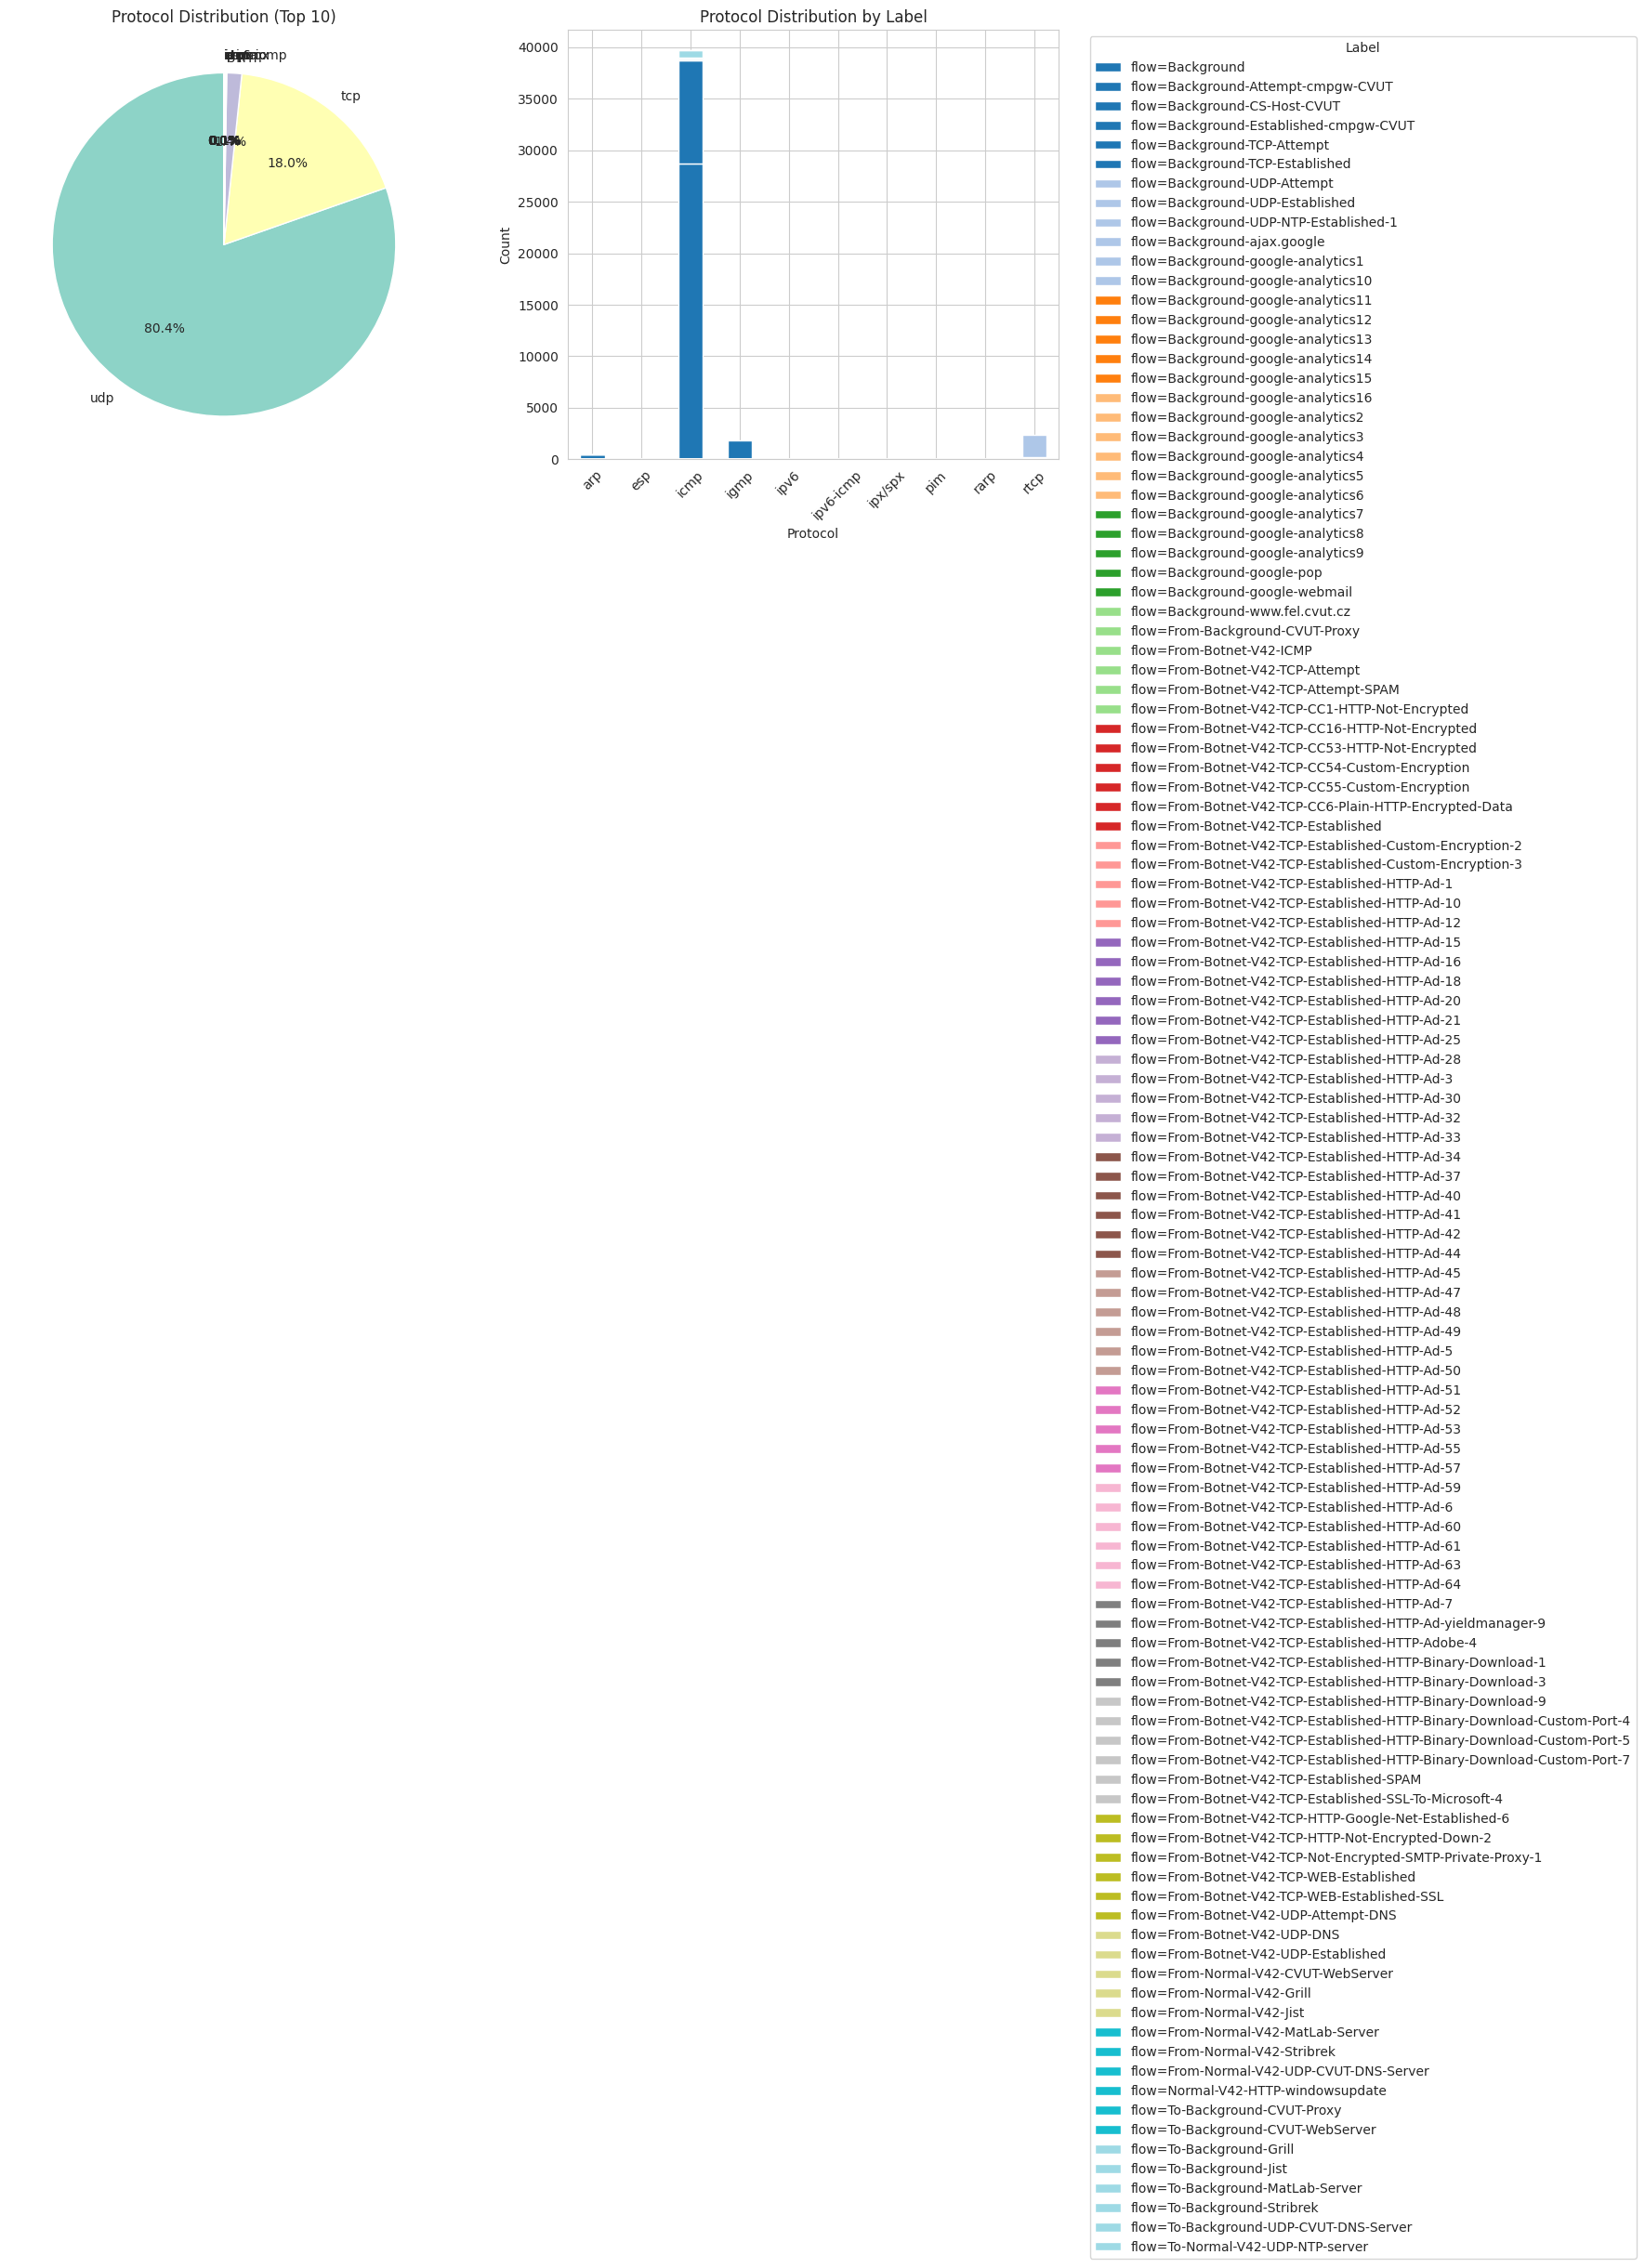


🌐 Protocol Statistics:
Proto
udp          2270083
tcp           507557
icmp           39694
rtp             2570
rtcp            2339
igmp            1803
arp              477
ipv6-icmp         58
ipx/spx           13
esp               10
ipv6              10
udt               10
pim                7
rarp               4
unas               1
Name: count, dtype: int64


In [11]:
# 2. Protocol Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Protocol counts
proto_counts = df['Proto'].value_counts().head(10)
colors_proto = plt.cm.Set3(range(len(proto_counts)))

ax1.pie(proto_counts.values, labels=proto_counts.index, autopct='%1.1f%%',
        colors=colors_proto, startangle=90)
ax1.set_title('Protocol Distribution (Top 10)')

# Protocol by label
proto_by_label = pd.crosstab(df['Proto'], df['Label'])
proto_by_label.head(10).plot(kind='bar', stacked=True, ax=ax2, colormap='tab20')
ax2.set_xlabel('Protocol')
ax2.set_ylabel('Count')
ax2.set_title('Protocol Distribution by Label')
ax2.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n🌐 Protocol Statistics:")
print("=" * 80)
print(df['Proto'].value_counts())

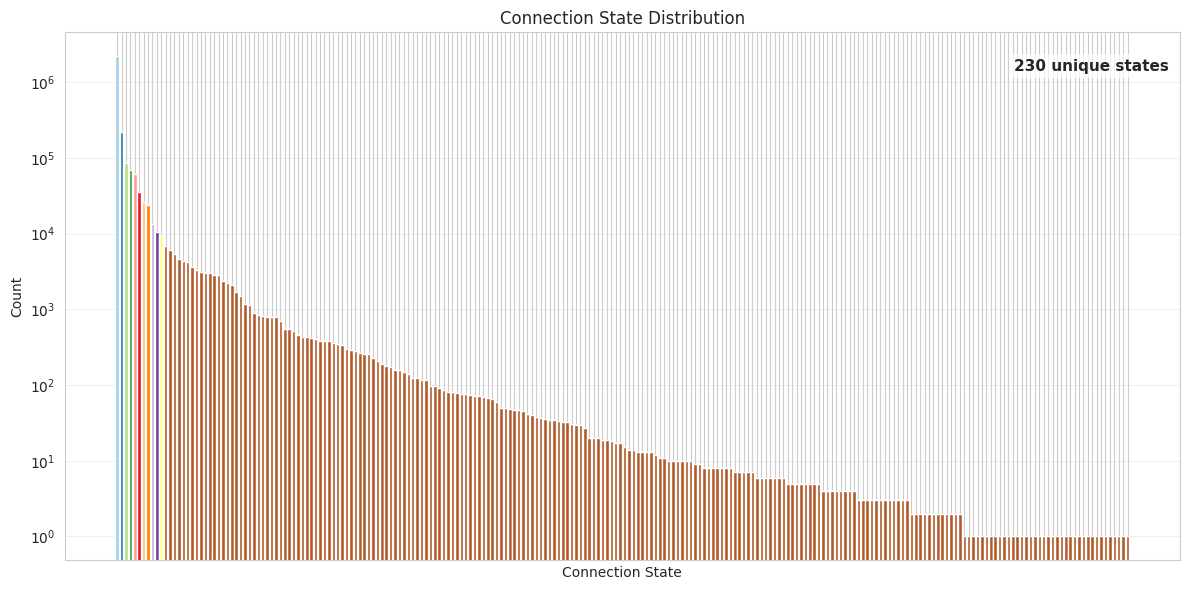


🔌 Connection State Statistics:
Total unique connection states: 230


In [26]:
# 3. Connection State Distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

state_counts = df['State'].value_counts()
colors_state = plt.cm.Paired(range(len(state_counts)))

bars = ax.bar(range(len(state_counts)), state_counts.values, color=colors_state)
ax.set_xticks(range(len(state_counts)))
# Hide x-axis tick labels to reduce clutter
ax.tick_params(axis='x', which='both', labelbottom=False)
ax.set_xlabel('Connection State')
ax.set_ylabel('Count')
ax.set_title('Connection State Distribution')
ax.set_yscale('log')  # Log scale for better visualization
ax.grid(axis='y', alpha=0.3)

# Add summary annotation instead of per-bar labels
ax.text(0.99, 0.95, f"{len(state_counts)} unique states",
        transform=ax.transAxes, ha='right', va='top',
        fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='none'))

plt.tight_layout()
plt.show()

print("\n🔌 Connection State Statistics:")
print("=" * 80)
print(f"Total unique connection states: {len(state_counts)}")

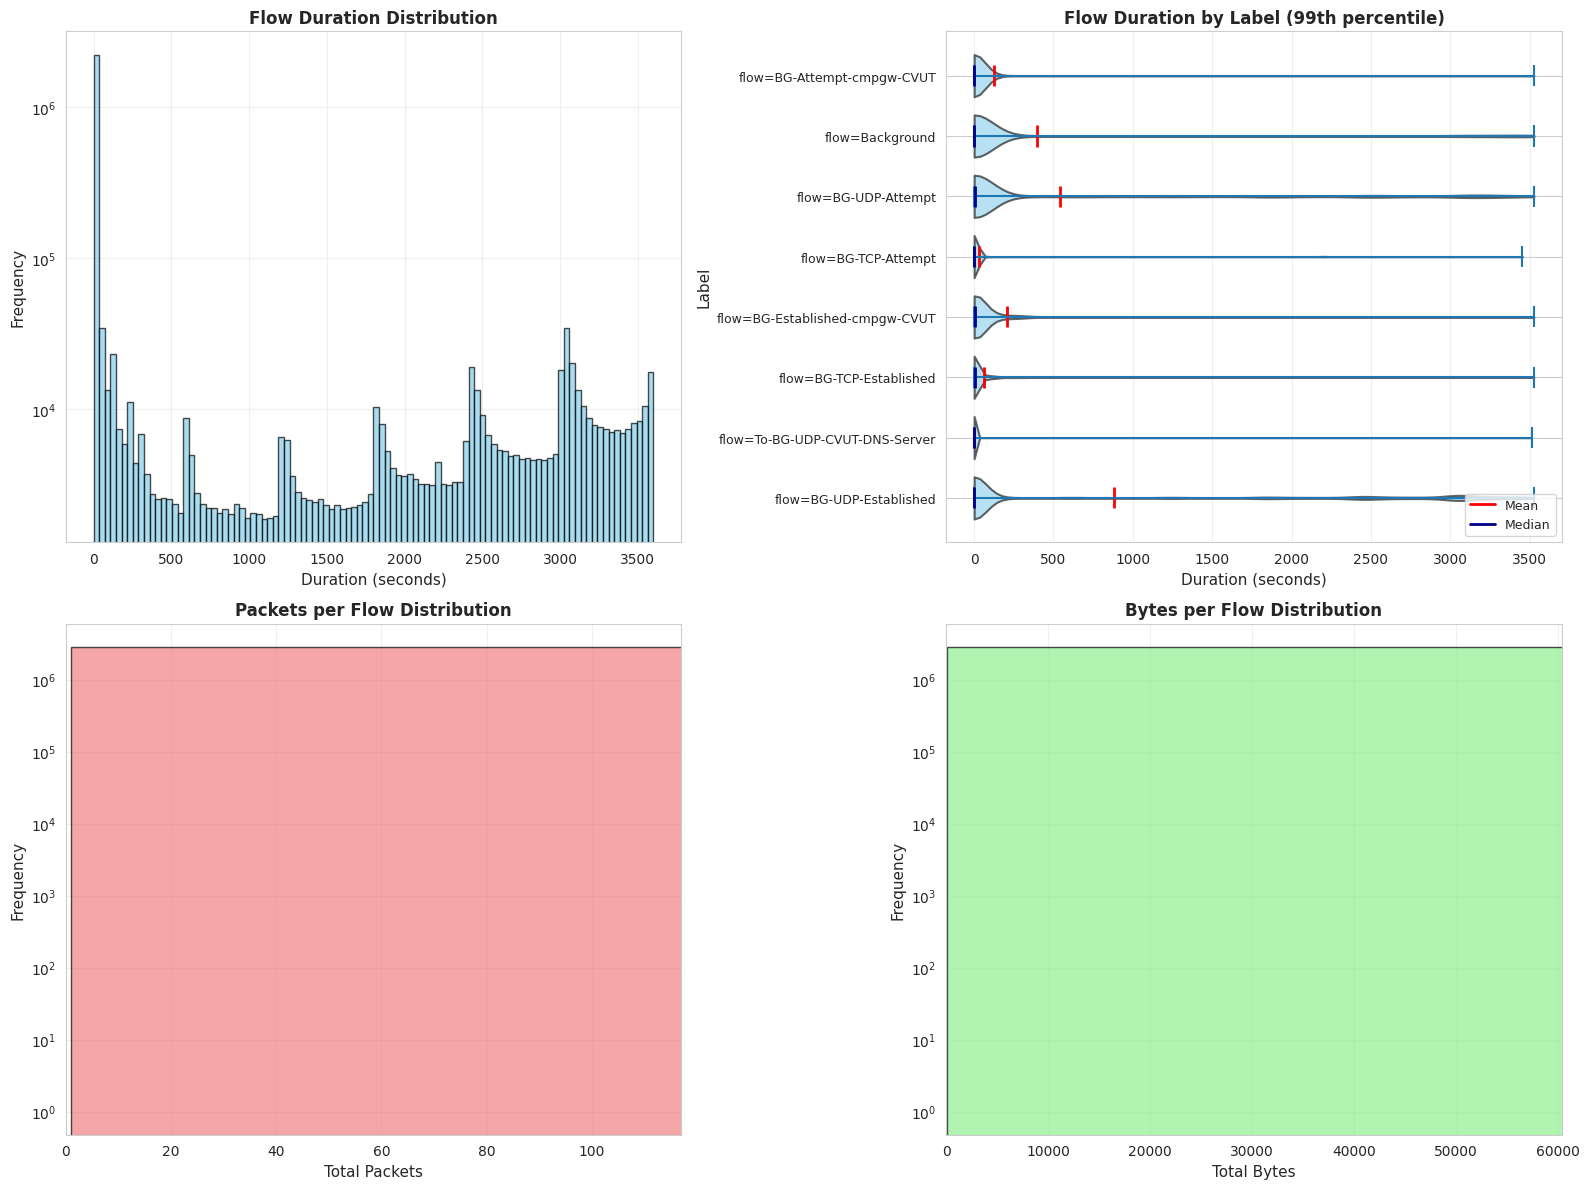


📈 Flow Characteristics:
                Dur       TotPkts      TotBytes      SrcBytes
count  2.824636e+06  2.824636e+06  2.824636e+06  2.824636e+06
mean   4.322060e+02  2.547990e+01  1.929134e+04  4.155290e+03
std    9.958423e+02  3.124788e+03  3.212186e+06  1.858530e+06
min    0.000000e+00  1.000000e+00  6.000000e+01  0.000000e+00
25%    3.130000e-04  2.000000e+00  2.140000e+02  7.800000e+01
50%    1.194000e-03  2.000000e+00  2.610000e+02  8.300000e+01
75%    9.012607e+00  4.000000e+00  5.880000e+02  2.610000e+02
max    3.600031e+03  2.686731e+06  2.689640e+09  2.635366e+09
                Dur       TotPkts      TotBytes      SrcBytes
count  2.824636e+06  2.824636e+06  2.824636e+06  2.824636e+06
mean   4.322060e+02  2.547990e+01  1.929134e+04  4.155290e+03
std    9.958423e+02  3.124788e+03  3.212186e+06  1.858530e+06
min    0.000000e+00  1.000000e+00  6.000000e+01  0.000000e+00
25%    3.130000e-04  2.000000e+00  2.140000e+02  7.800000e+01
50%    1.194000e-03  2.000000e+00  2.610000e+

In [25]:
# 4. Flow Duration Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall duration distribution (log scale)
axes[0, 0].hist(df['Dur'].dropna(), bins=100, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Duration (seconds)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Flow Duration Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(alpha=0.3)

# Duration by label (violin plot for better visualization)
# Filter out extreme outliers for better visualization
duration_data = df[df['Dur'] < df['Dur'].quantile(0.99)].copy()  # Use 99th percentile
labels_to_plot = duration_data['Label'].value_counts().head(8).index

# Shorten label names for better display
label_mapping = {label: label.replace('Background-', 'BG-').replace('Botnet-', 'Bot-')[:35] 
                 for label in labels_to_plot}

# Prepare data for violin plot
plot_data = []
plot_labels = []
for label in labels_to_plot:
    data = duration_data[duration_data['Label'] == label]['Dur'].dropna().values
    if len(data) > 0:
        plot_data.append(data)
        plot_labels.append(label_mapping[label])

# Create violin plot
parts = axes[0, 1].violinplot(plot_data, vert=False, 
                               widths=0.7,
                               showmeans=True, 
                               showmedians=True)

# Color the violin plots
for pc in parts['bodies']:
    pc.set_facecolor('#87CEEB')
    pc.set_alpha(0.6)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

# Style the mean and median lines
parts['cmeans'].set_color('red')
parts['cmeans'].set_linewidth(2)
parts['cmedians'].set_color('darkblue')
parts['cmedians'].set_linewidth(2)

# Set y-axis labels
axes[0, 1].set_yticks(range(1, len(plot_labels) + 1))
axes[0, 1].set_yticklabels(plot_labels, fontsize=9)
axes[0, 1].set_xlabel('Duration (seconds)', fontsize=11)
axes[0, 1].set_ylabel('Label', fontsize=11)
axes[0, 1].set_title('Flow Duration by Label (99th percentile)', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2, label='Mean'),
    Line2D([0], [0], color='darkblue', linewidth=2, label='Median')
]
axes[0, 1].legend(handles=legend_elements, loc='lower right', fontsize=9)

# Packets distribution
axes[1, 0].hist(df['TotPkts'], bins=100, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Total Packets', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Packets per Flow Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(0, df['TotPkts'].quantile(0.99))
axes[1, 0].grid(alpha=0.3)

# Bytes distribution
axes[1, 1].hist(df['TotBytes'], bins=100, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Total Bytes', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Bytes per Flow Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlim(0, df['TotBytes'].quantile(0.99))
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


print("\n📈 Flow Characteristics:")
print("=" * 80)
print(df[['Dur', 'TotPkts', 'TotBytes', 'SrcBytes']].describe())

/tmp/ipykernel_18643/3144396434.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


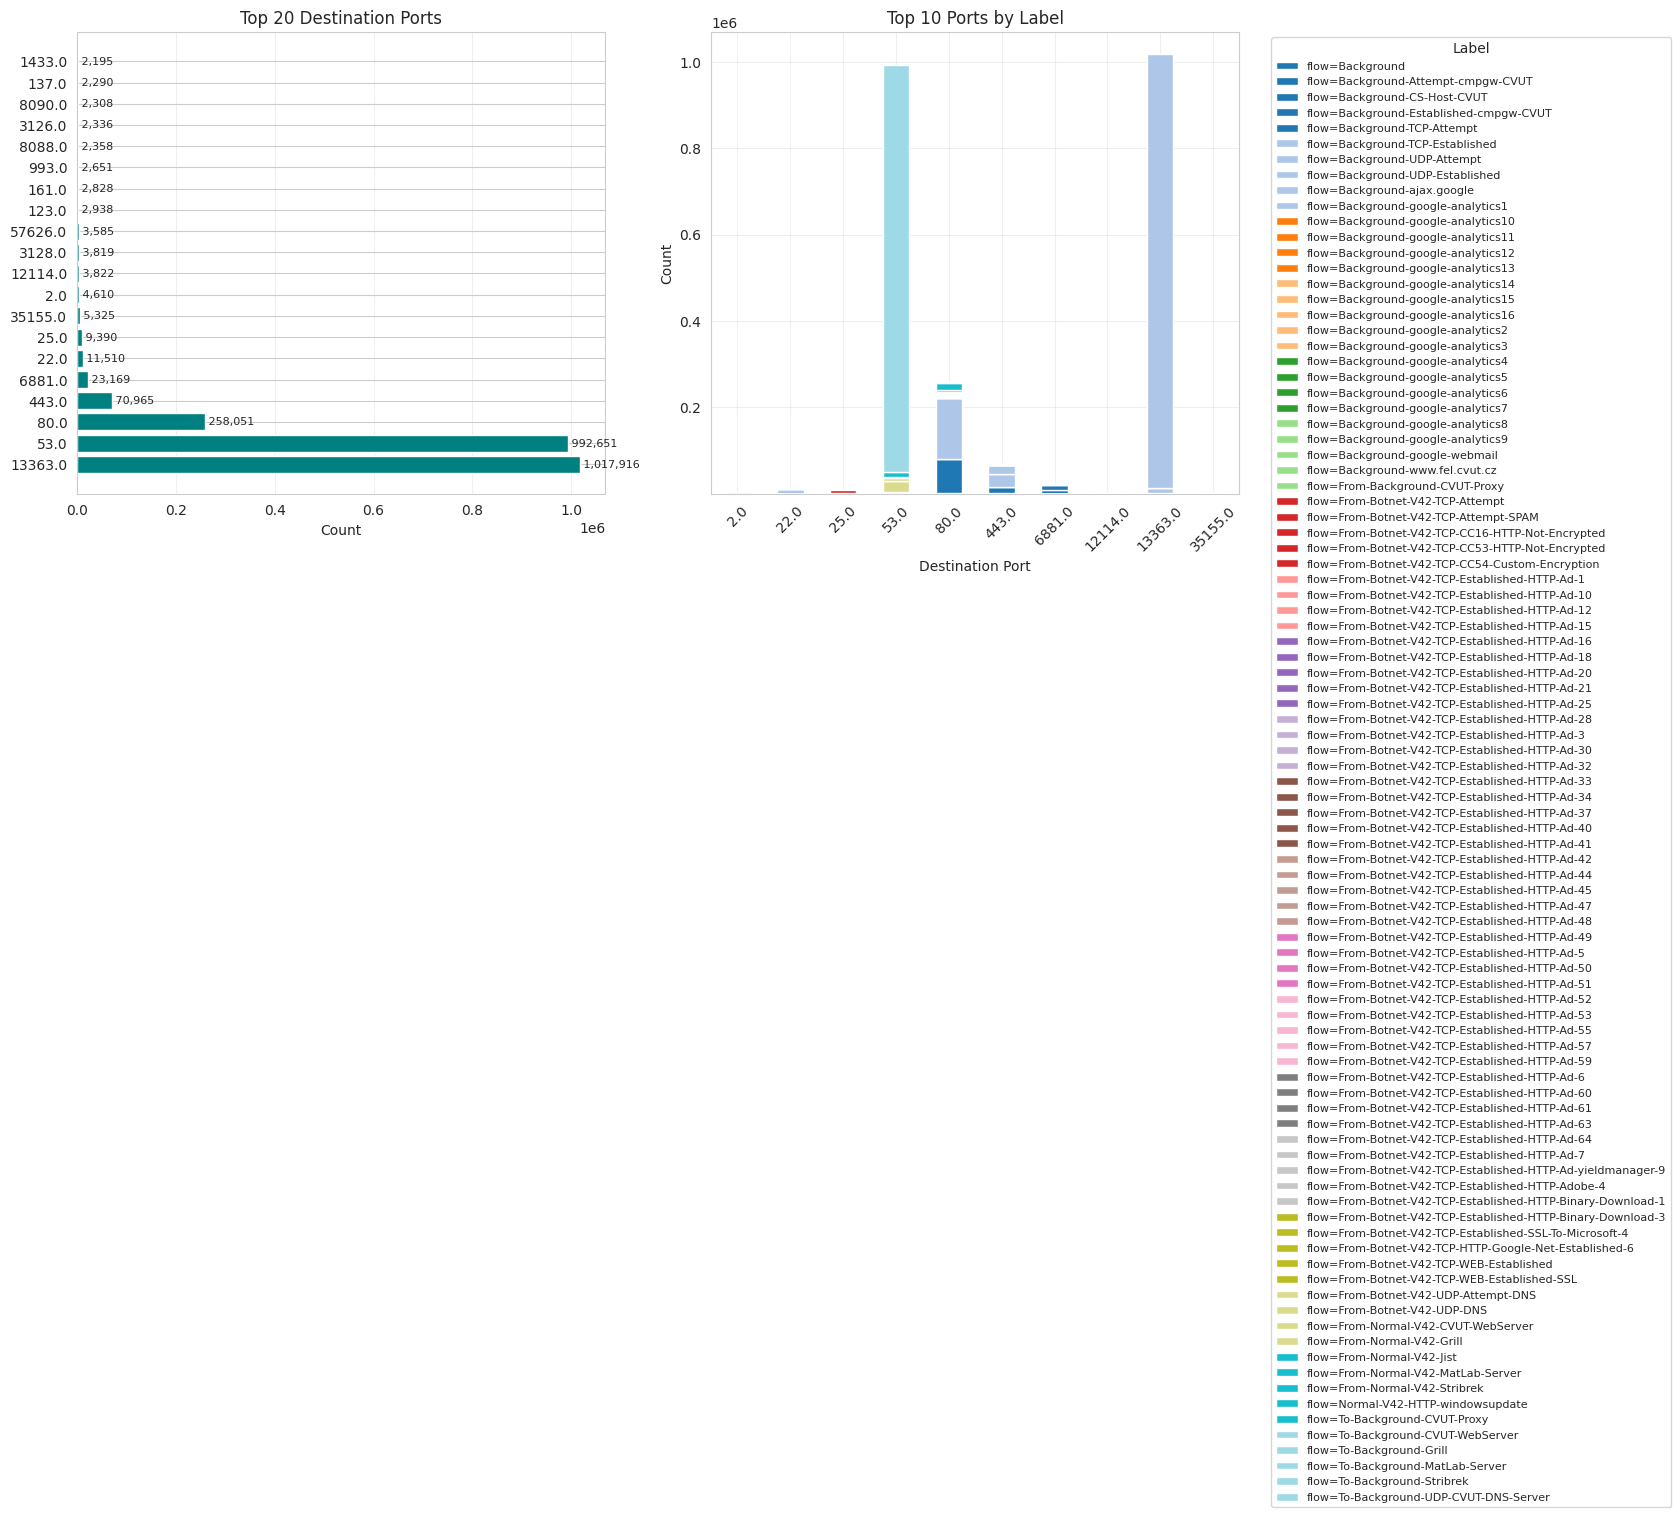


🔌 Top Destination Ports:
Dport
13363.0    1017916
53.0        992651
80.0        258051
443.0        70965
6881.0       23169
22.0         11510
25.0          9390
35155.0       5325
2.0           4610
12114.0       3822
3128.0        3819
57626.0       3585
123.0         2938
161.0         2828
993.0         2651
8088.0        2358
3126.0        2336
8090.0        2308
137.0         2290
1433.0        2195
Name: count, dtype: int64


In [14]:
# 5. Top Destination Ports
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Top 20 destination ports
top_ports = df['Dport'].value_counts().head(20)
ax1.barh(range(len(top_ports)), top_ports.values, color='teal')
ax1.set_yticks(range(len(top_ports)))
ax1.set_yticklabels(top_ports.index)
ax1.set_xlabel('Count')
ax1.set_title('Top 20 Destination Ports')
ax1.grid(axis='x', alpha=0.3)

# Add port labels with counts
for i, (port, count) in enumerate(zip(top_ports.index, top_ports.values)):
    ax1.text(count, i, f' {count:,}', va='center', fontsize=8)

# Port distribution by label (top 10 ports)
top_10_ports = df['Dport'].value_counts().head(10).index
port_label_data = df[df['Dport'].isin(top_10_ports)]
port_by_label = pd.crosstab(port_label_data['Dport'], port_label_data['Label'])

port_by_label.plot(kind='bar', stacked=True, ax=ax2, colormap='tab20')
ax2.set_xlabel('Destination Port')
ax2.set_ylabel('Count')
ax2.set_title('Top 10 Ports by Label')
ax2.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔌 Top Destination Ports:")
print("=" * 80)
print(top_ports)

/tmp/ipykernel_18643/3368900474.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_time = df.set_index('StartTime').resample('1H').size()
/tmp/ipykernel_18643/3368900474.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  label_data = df[df['Label'] == label].set_index('StartTime').resample('1H').size()
/tmp/ipykernel_18643/3368900474.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  label_data = df[df['Label'] == label].set_index('StartTime').resample('1H').size()
/tmp/ipykernel_18643/3368900474.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  label_data = df[df['Label'] == label].set_index('StartTime').resample('1H').size()
/tmp/ipykernel_18643/3368900474.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
 

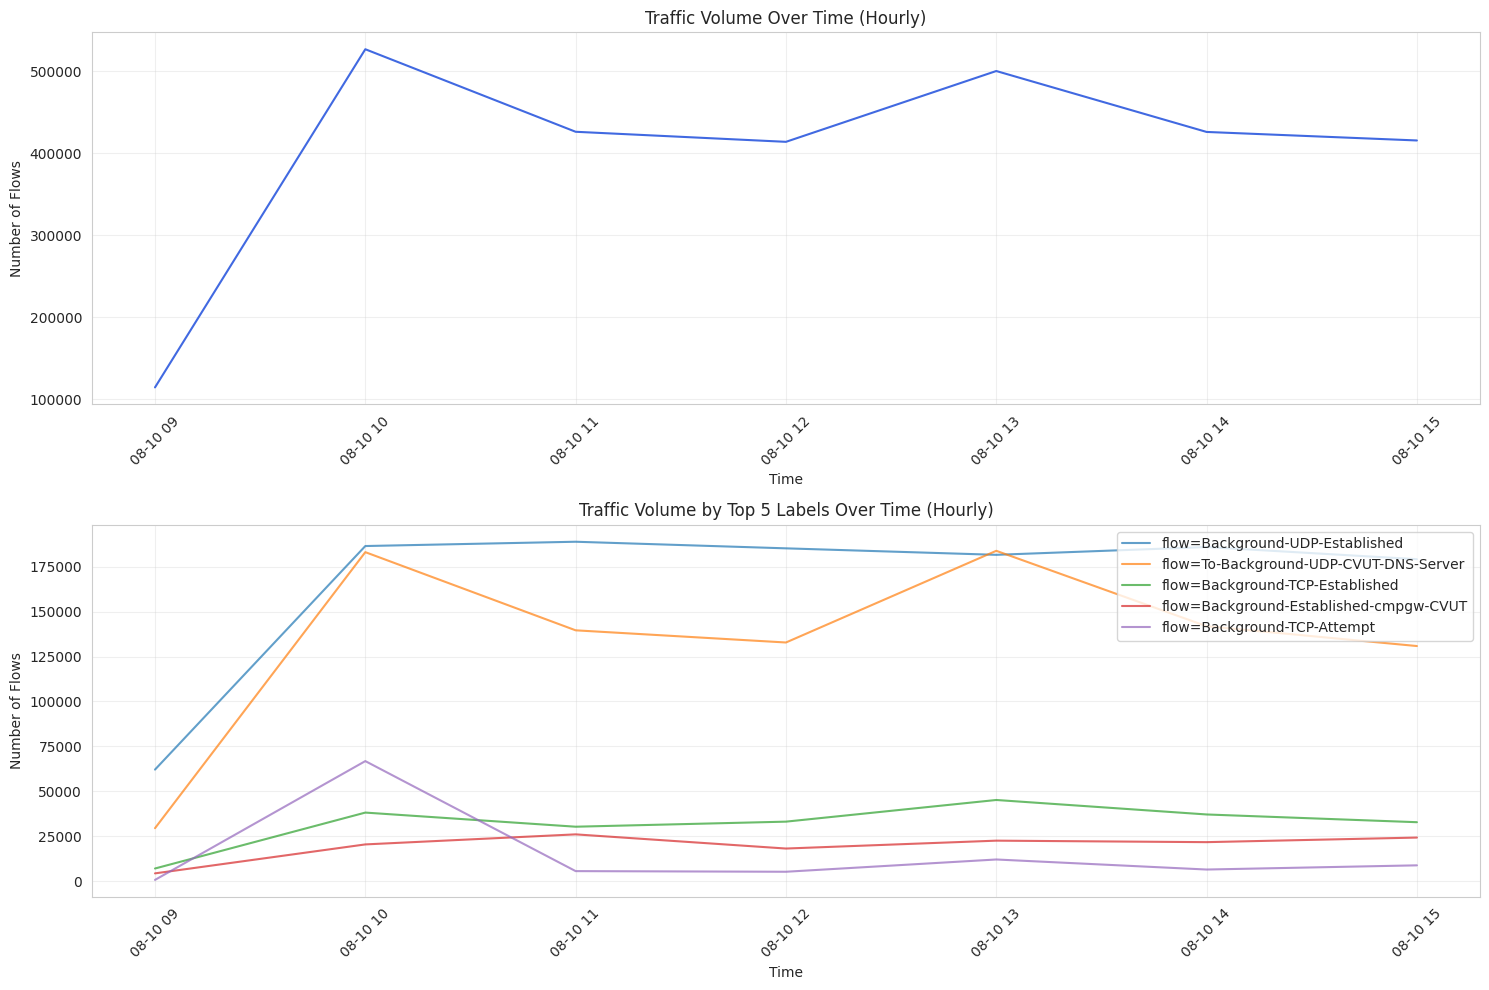


⏰ Temporal Statistics:
Time Range: 2011-08-10 09:46:53.047277 to 2011-08-10 15:54:07.368340
Duration: 0 days 06:07:14.321063

Flows per hour statistics:
count         7.000000
mean     403519.428571
std      135145.480118
min      114407.000000
25%      414962.500000
50%      426202.000000
75%      463481.500000
max      527139.000000
dtype: float64


In [15]:
# 6. Temporal Analysis
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Traffic over time
df_time = df.set_index('StartTime').resample('1H').size()
axes[0].plot(df_time.index, df_time.values, color='royalblue', linewidth=1.5)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Number of Flows')
axes[0].set_title('Traffic Volume Over Time (Hourly)')
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Traffic by label over time
for label in df['Label'].value_counts().head(5).index:
    label_data = df[df['Label'] == label].set_index('StartTime').resample('1H').size()
    axes[1].plot(label_data.index, label_data.values, label=label, linewidth=1.5, alpha=0.7)

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Number of Flows')
axes[1].set_title('Traffic Volume by Top 5 Labels Over Time (Hourly)')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Time-based statistics
print("\n⏰ Temporal Statistics:")
print("=" * 80)
print(f"Time Range: {df['StartTime'].min()} to {df['StartTime'].max()}")
print(f"Duration: {df['StartTime'].max() - df['StartTime'].min()}")
print(f"\nFlows per hour statistics:")
print(df_time.describe())

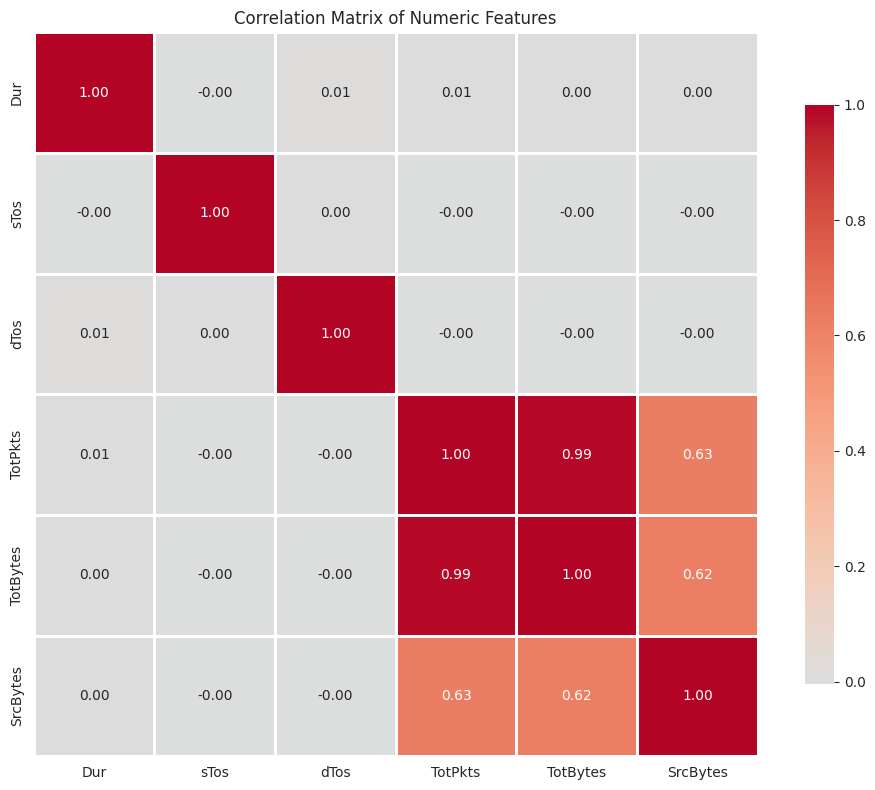


🔗 Correlation Matrix:
               Dur      sTos      dTos   TotPkts  TotBytes  SrcBytes
Dur       1.000000 -0.003867  0.010184  0.007332  0.004601  0.003075
sTos     -0.003867  1.000000  0.000421 -0.000089 -0.000073 -0.000024
dTos      0.010184  0.000421  1.000000 -0.000049 -0.000067 -0.000023
TotPkts   0.007332 -0.000089 -0.000049  1.000000  0.990444  0.631172
TotBytes  0.004601 -0.000073 -0.000067  0.990444  1.000000  0.616594
SrcBytes  0.003075 -0.000024 -0.000023  0.631172  0.616594  1.000000


In [16]:
# 7. Correlation Heatmap for Numeric Features
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Select numeric columns
numeric_cols = ['Dur', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes']
correlation_matrix = df[numeric_cols].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix of Numeric Features')

plt.tight_layout()
plt.show()

print("\n🔗 Correlation Matrix:")
print("=" * 80)
print(correlation_matrix)

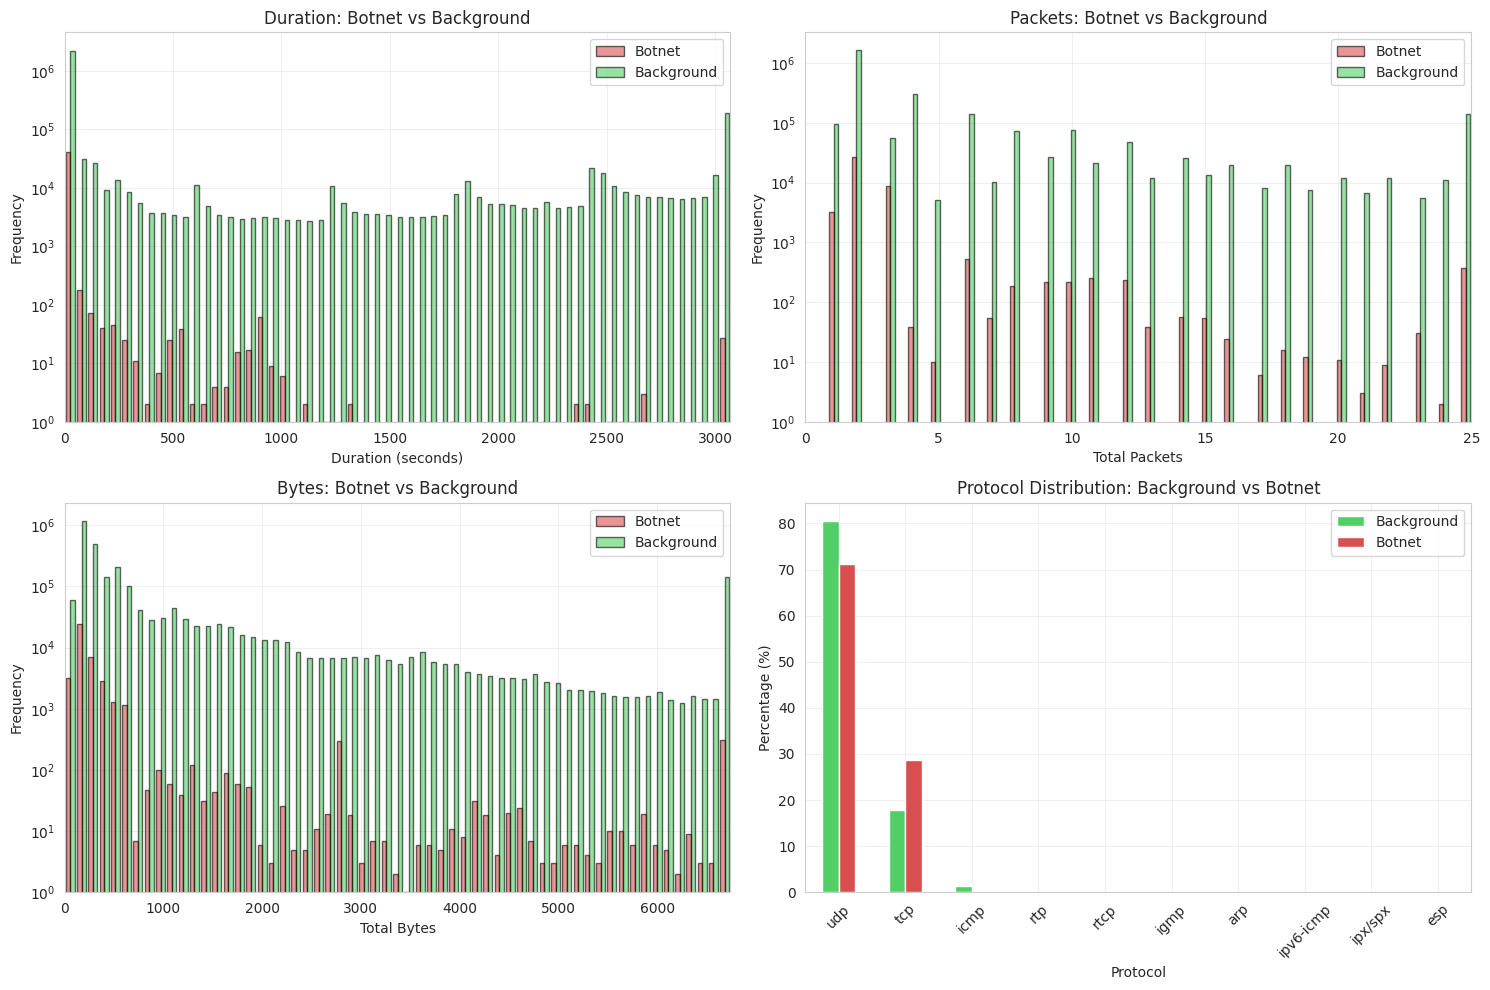


⚔️ Botnet vs Background Statistics:
Botnet flows: 40,961 (1.45%)
Background flows: 2,783,675 (98.55%)

Numeric features comparison (clipped at 95th percentile for visualization):
                  Dur    TotPkts      TotBytes     SrcBytes
is_botnet                                                  
False      438.398026  25.782323  19561.381467  4211.311592
True        11.398101   4.927321    939.254901   348.118649

Top protocols by total flows (Top 10):
is_botnet  Background  Botnet    Total
Proto                                 
udp           2240880   29203  2270083
tcp            495801   11756   507557
icmp            39692       2    39694
rtp              2570       0     2570
rtcp             2339       0     2339
igmp             1803       0     1803
arp               477       0      477
ipv6-icmp          58       0       58
ipx/spx            13       0       13
esp                10       0       10


In [17]:
import numpy as np

# 8. Attack vs Normal Traffic Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Create binary classification (Botnet vs Background)
df['is_botnet'] = df['Label'].str.contains('Botnet', case=False, na=False)

feature_configs = [
    {
        'feature': 'Dur',
        'ax': axes[0, 0],
        'xlabel': 'Duration (seconds)',
        'title': 'Duration: Botnet vs Background',
        'bins': 60
    },
    {
        'feature': 'TotPkts',
        'ax': axes[0, 1],
        'xlabel': 'Total Packets',
        'title': 'Packets: Botnet vs Background',
        'bins': 60
    },
    {
        'feature': 'TotBytes',
        'ax': axes[1, 0],
        'xlabel': 'Total Bytes',
        'title': 'Bytes: Botnet vs Background',
        'bins': 60
    }
 ]

for config in feature_configs:
    feature = config['feature']
    ax = config['ax']
    limit = df[feature].quantile(0.95)
    if not np.isfinite(limit) or limit <= 0:
        limit = df[feature].dropna().max()
    if not np.isfinite(limit) or limit <= 0:
        limit = 1

    botnet_values = df.loc[df['is_botnet'], feature].dropna().clip(upper=limit)
    background_values = df.loc[~df['is_botnet'], feature].dropna().clip(upper=limit)

    bins = np.linspace(0, limit, max(3, config.get('bins', 50)))
    ax.hist([botnet_values, background_values], bins=bins,
            label=['Botnet', 'Background'],
            color=['#d94f4f', '#51cf66'], alpha=0.6, edgecolor='black')
    ax.set_xlabel(config['xlabel'])
    ax.set_ylabel('Frequency')
    ax.set_title(config['title'])
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(bottom=1)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, limit)

# Protocol distribution comparison
proto_counts = pd.crosstab(df['Proto'], df['is_botnet'])
proto_totals = proto_counts.sum(axis=1)
top_protocols = proto_totals.sort_values(ascending=False).head(10).index
column_totals = proto_counts.sum(axis=0).replace(0, np.nan)
proto_percent = proto_counts.div(column_totals, axis=1) * 100
proto_percent = proto_percent.loc[top_protocols].fillna(0)
proto_percent = proto_percent.rename(columns={False: 'Background', True: 'Botnet'})
proto_percent.plot(kind='bar', ax=axes[1, 1], color=['#51cf66', '#d94f4f'])
axes[1, 1].set_xlabel('Protocol')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].set_title('Protocol Distribution: Background vs Botnet')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚔️ Botnet vs Background Statistics:")
print("=" * 80)
botnet_flows = df['is_botnet'].sum()
background_flows = (~df['is_botnet']).sum()
print(f"Botnet flows: {botnet_flows:,} ({botnet_flows/len(df)*100:.2f}%)")
print(f"Background flows: {background_flows:,} ({background_flows/len(df)*100:.2f}%)")
print("\nNumeric features comparison (clipped at 95th percentile for visualization):")
print(df.groupby('is_botnet')[['Dur', 'TotPkts', 'TotBytes', 'SrcBytes']].mean())
print("\nTop protocols by total flows (Top 10):")
proto_summary = proto_counts.loc[top_protocols].assign(Total=proto_totals.loc[top_protocols])
proto_summary = proto_summary.rename(columns={False: 'Background', True: 'Botnet'})
print(proto_summary)

In [18]:
# 9. Botnet Host Insights
botnet_mask = df['Label'].str.contains('Botnet', case=False, na=False)
botnet_df = df[botnet_mask].copy()

def first_available_column(candidates, frame):
    for candidate in candidates:
        if candidate in frame.columns:
            return candidate
    return None

src_col = first_available_column(['SrcAddr', 'SrcIP', 'SourceAddr', 'Src Address'], botnet_df)
dst_col = first_available_column(['DstAddr', 'DstIP', 'DestinationAddr', 'Dst Address'], botnet_df)

print("\n🧠 Botnet Host Insights")
print("=" * 80)
print(f"Total botnet flows analyzed: {len(botnet_df):,}")

if src_col:
    top_sources = (botnet_df[src_col].value_counts().head(10)
                   .rename_axis('Source')
                   .reset_index(name='Flows'))
    top_sources['Percentage'] = (top_sources['Flows'] / len(botnet_df) * 100).round(2)
    print("\nTop Botnet Source Addresses:")
    display(top_sources.style.format({'Flows': '{:,}', 'Percentage': '{:.2f}%'}))
else:
    print("Source address column not found; skipping source summary.")

if dst_col:
    top_destinations = (botnet_df[dst_col].value_counts().head(10)
                       .rename_axis('Destination')
                       .reset_index(name='Flows'))
    top_destinations['Percentage'] = (top_destinations['Flows'] / len(botnet_df) * 100).round(2)
    print("\nTop Botnet Destination Addresses:")
    display(top_destinations.style.format({'Flows': '{:,}', 'Percentage': '{:.2f}%'}))
else:
    print("Destination address column not found; skipping destination summary.")

if 'Dport' in botnet_df.columns and 'Proto' in botnet_df.columns:
    top_ports = (botnet_df.groupby(['Proto', 'Dport'], observed=False).size()
                 .sort_values(ascending=False).head(10)
                 .rename('Flows').reset_index())
    top_ports['Percentage'] = (top_ports['Flows'] / len(botnet_df) * 100).round(2)
    print("\nTop Protocol/Destination Port pairs for Botnet traffic:")
    display(top_ports.style.format({'Flows': '{:,}', 'Percentage': '{:.2f}%'}))
else:
    print("Protocol or destination port columns not available; skipping port summary.")


🧠 Botnet Host Insights
Total botnet flows analyzed: 40,961

Top Botnet Source Addresses:


,Source,Flows,Percentage
0,147.32.84.165,"40,961",100.00%



Top Botnet Destination Addresses:


,Destination,Flows,Percentage
0,147.32.80.9,"7,420",18.11%
1,194.85.105.17,"1,160",2.83%
2,193.232.128.6,"1,128",2.75%
3,194.85.252.62,"1,093",2.67%
4,193.232.142.17,"1,087",2.65%
5,192.93.0.4,994,2.43%
6,193.232.156.17,992,2.42%
7,209.85.225.27,960,2.34%
8,212.117.174.7,827,2.02%
9,174.133.57.141,352,0.86%



Top Protocol/Destination Port pairs for Botnet traffic:


,Proto,Dport,Flows,Percentage
0,udp,53.000000,"29,197",71.28%
1,tcp,25.000000,"8,105",19.79%
2,tcp,80.000000,"1,243",3.03%
3,tcp,6667.000000,974,2.38%
4,tcp,4506.000000,827,2.02%
5,tcp,65500.000000,320,0.78%
6,tcp,443.000000,119,0.29%
7,tcp,587.000000,62,0.15%
8,tcp,3128.000000,29,0.07%
9,tcp,4190.000000,13,0.03%


In [19]:
# 10. Label-Level Summary Metrics
label_summary = (
    df.groupby('Label', observed=False).agg(
        Flows=('Label', 'size'),
        Flow_Percentage=('Label', lambda x: len(x) / len(df) * 100),
        Avg_Duration_s=('Dur', 'mean'),
        Median_Duration_s=('Dur', 'median'),
        Avg_Total_Packets=('TotPkts', 'mean'),
        Avg_Total_Bytes=('TotBytes', 'mean'),
        Avg_Source_Bytes=('SrcBytes', 'mean'),
        Total_Bytes=('TotBytes', 'sum')
    )
    .sort_values('Flows', ascending=False)
)

display(
    label_summary.style
    .format({
        'Flows': '{:,.0f}',
        'Flow_Percentage': '{:.2f}%',
        'Avg_Duration_s': '{:,.2f}',
        'Median_Duration_s': '{:,.2f}',
        'Avg_Total_Packets': '{:,.2f}',
        'Avg_Total_Bytes': '{:,.2f}',
        'Avg_Source_Bytes': '{:,.2f}',
        'Total_Bytes': '{:,.0f}'
    })
    .set_caption('Label-Level Flow Statistics')
)

,Flows,Flow_Percentage,Avg_Duration_s,Median_Duration_s,Avg_Total_Packets,Avg_Total_Bytes,Avg_Source_Bytes,Total_Bytes
Label,,,,,,,,
flow=Background-UDP-Established,"1,169,677",41.41%,928.15,0.01,6.14,"1,682.45",441.45,"1,967,917,298"
flow=To-Background-UDP-CVUT-DNS-Server,"941,706",33.34%,0.71,0.00,2.00,244.08,80.39,"229,847,557"
flow=Background-TCP-Established,"223,543",7.91%,90.05,2.52,139.66,"116,200.85","35,628.81","25,975,885,497"
flow=Background-Established-cmpgw-CVUT,"137,257",4.86%,232.33,6.06,138.78,"134,791.94","8,908.24","18,501,137,357"
flow=Background-TCP-Attempt,"105,438",3.73%,29.65,0.63,2.81,184.85,130.29,"19,490,335"
flow=Background-UDP-Attempt,"66,699",2.36%,584.41,6.00,8.18,"1,136.67","1,136.01","75,814,985"
flow=Background,"40,216",1.42%,662.80,0.00,91.54,"35,675.78","28,135.56","1,434,737,325"
flow=Background-Attempt-cmpgw-CVUT,"30,983",1.10%,137.14,0.00,2.61,292.51,292.49,"9,062,754"
flow=From-Botnet-V42-UDP-DNS,"26,140",0.93%,1.10,0.06,2.00,257.86,73.38,"6,740,342"


In [20]:
# 11. Scenario Coverage Diagnostics
print("Dataset columns:\n", df.columns.tolist())
label_counts = df['Label'].value_counts()
print("\nTop label categories:")
display(label_counts.head(20).to_frame('Flows'))

Dataset columns:
 ['StartTime', 'Dur', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes', 'Label', 'is_botnet']

Top label categories:


,Flows
Label,
flow=Background-UDP-Established,1169677
flow=To-Background-UDP-CVUT-DNS-Server,941706
flow=Background-TCP-Established,223543
flow=Background-Established-cmpgw-CVUT,137257
flow=Background-TCP-Attempt,105438
flow=Background-UDP-Attempt,66699
flow=Background,40216
flow=Background-Attempt-cmpgw-CVUT,30983
flow=From-Botnet-V42-UDP-DNS,26140


In [21]:
# 12. Scenario Coverage Summary
df['Scenario'] = df['Label'].str.extract(r'(V\d{2})').fillna('Unknown')
scenario_counts = (
    df['Scenario']
    .value_counts()
    .rename_axis('Scenario')
    .reset_index(name='Flows')
)
scenario_counts['Percentage'] = (scenario_counts['Flows'] / len(df) * 100).round(2)
print("Scenario coverage across CTU-13 subset:")
display(scenario_counts.style.format({'Flows': '{:,}', 'Percentage': '{:.2f}%'}))

Scenario coverage across CTU-13 subset:


,Scenario,Flows,Percentage
0,Unknown,"2,753,288",97.47%
1,V42,"71,348",2.53%


In [22]:
# 13. Label Mix by Scenario
scenario_label_mix = (
    df.groupby(['Scenario', 'is_botnet'], observed=False).size()
    .unstack(fill_value=0)
    .rename(columns={False: 'Background/Normal', True: 'Botnet'})
)
scenario_label_mix['Total'] = scenario_label_mix.sum(axis=1)
scenario_label_mix['Botnet_%'] = (scenario_label_mix['Botnet'] / scenario_label_mix['Total'] * 100).round(2)
scenario_label_mix['Background_%'] = (scenario_label_mix['Background/Normal'] / scenario_label_mix['Total'] * 100).round(2)
scenario_label_mix = scenario_label_mix.sort_values('Botnet', ascending=False)

styled_scenario_mix = (
    scenario_label_mix.style
    .format({
        'Background/Normal': '{:,.0f}',
        'Botnet': '{:,.0f}',
        'Total': '{:,.0f}',
        'Botnet_%': '{:.2f}%',
        'Background_%': '{:.2f}%'
    })
    .set_caption('Label Mix by Scenario Based on is_botnet Flag')
)
display(styled_scenario_mix)

is_botnet,Background/Normal,Botnet,Total,Botnet_%,Background_%
Scenario,,,,,
V42,"30,387","40,961","71,348",57.41%,42.59%
Unknown,"2,753,288",0,"2,753,288",0.00%,100.00%


### CTU-13 Scenario Notes for C2 Beaconing EDA
- The NetFlow export aggregates more than 2.8 million background/normal flows without an explicit scenario tag; these constitute the ambient traffic our anomaly models must treat as benign.
- Scenario **V42** is the only capture in this subset with explicit botnet annotations (≈41k malicious flows) and still contains ~30k labeled background flows from the same time window, giving us a realistic class imbalance for C2 beaconing detection.
- For a privacy-preserving federated setup, V42 can act as an initial "infected" client, while the large background pool can be partitioned across additional clients to simulate collaborative learning without sharing raw packets.

In [23]:
# 14. Export Key Figures for LaTeX Report
from pathlib import Path

report_fig_dir = Path("../docs/figures")
report_fig_dir.mkdir(parents=True, exist_ok=True)

# 14.1 Label Distribution Figure
top_n = 10
label_counts = df['Label'].value_counts()
top_labels = label_counts.head(top_n)
others_count = label_counts.iloc[top_n:].sum()
plot_counts = top_labels.copy()
if others_count > 0:
    plot_counts = pd.concat([plot_counts, pd.Series({'Others': others_count})])
label_pct = (plot_counts / len(df) * 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
colors = ['#ff6b6b' if 'Botnet' in str(label) else '#51cf66' for label in plot_counts.index]
bars1 = ax1.barh(range(len(plot_counts)), plot_counts.values, color=colors)
ax1.set_yticks(range(len(plot_counts)))
ax1.set_yticklabels(plot_counts.index, fontsize=9)
ax1.set_xlabel('Count', fontsize=11)
ax1.set_ylabel('Label', fontsize=11)
ax1.set_title(f'Label Distribution (Top {top_n} + Others)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()
for bar, count in zip(bars1, plot_counts.values):
    ax1.text(count, bar.get_y() + bar.get_height() / 2, f'{count:,.0f}', va='center', fontsize=9)

wedges, _, autotexts = ax2.pie(plot_counts.values, labels=None, autopct='%1.1f%%',
                               colors=colors, startangle=90, pctdistance=0.8)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')
ax2.legend(wedges, plot_counts.index, title='Labels', loc='center left',
           bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)
ax2.set_title('Percentage Share', fontsize=13, fontweight='bold')
fig.tight_layout()
fig.savefig(report_fig_dir / "label_distribution.png", dpi=300, bbox_inches='tight')
plt.close(fig)

# 14.2 Connection State Distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
state_counts = df['State'].value_counts()
colors_state = plt.cm.Paired(range(len(state_counts)))
ax.bar(range(len(state_counts)), state_counts.values, color=colors_state)
ax.set_xticks(range(len(state_counts)))
ax.tick_params(axis='x', which='both', labelbottom=False)
ax.set_xlabel('Connection State')
ax.set_ylabel('Count')
ax.set_title('Connection State Distribution')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3)
ax.text(0.99, 0.95, f"{len(state_counts)} unique states", transform=ax.transAxes,
        ha='right', va='top', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='none'))
fig.tight_layout()
fig.savefig(report_fig_dir / "connection_state_distribution.png", dpi=300, bbox_inches='tight')
plt.close(fig)

# 14.3 Botnet vs Background Comparison
feature_configs = [
    {
        'feature': 'Dur',
        'xlabel': 'Duration (seconds)',
        'title': 'Duration: Botnet vs Background',
    },
    {
        'feature': 'TotPkts',
        'xlabel': 'Total Packets',
        'title': 'Packets: Botnet vs Background',
    },
    {
        'feature': 'TotBytes',
        'xlabel': 'Total Bytes',
        'title': 'Bytes: Botnet vs Background',
    }
]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes_flat = axes.flatten()
for idx, config in enumerate(feature_configs):
    feature = config['feature']
    ax = axes_flat[idx]
    limit = df[feature].quantile(0.95)
    if not np.isfinite(limit) or limit <= 0:
        limit = df[feature].dropna().max()
    if not np.isfinite(limit) or limit <= 0:
        limit = 1
    botnet_values = df.loc[df['is_botnet'], feature].dropna().clip(upper=limit)
    background_values = df.loc[~df['is_botnet'], feature].dropna().clip(upper=limit)
    bins = np.linspace(0, limit, 60)
    ax.hist([botnet_values, background_values], bins=bins, label=['Botnet', 'Background'],
            color=['#d94f4f', '#51cf66'], alpha=0.6, edgecolor='black')
    ax.set_xlabel(config['xlabel'])
    ax.set_ylabel('Frequency')
    ax.set_title(config['title'])
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(bottom=1)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, limit)

proto_counts = pd.crosstab(df['Proto'], df['is_botnet'])
proto_totals = proto_counts.sum(axis=1)
top_protocols = proto_totals.sort_values(ascending=False).head(10).index
column_totals = proto_counts.sum(axis=0).replace(0, np.nan)
proto_percent = proto_counts.div(column_totals, axis=1) * 100
proto_percent = proto_percent.loc[top_protocols].fillna(0)
proto_percent = proto_percent.rename(columns={False: 'Background', True: 'Botnet'})
proto_percent.plot(kind='bar', ax=axes_flat[3], color=['#51cf66', '#d94f4f'])
axes_flat[3].set_xlabel('Protocol')
axes_flat[3].set_ylabel('Percentage (%)')
axes_flat[3].set_title('Protocol Distribution: Background vs Botnet')
axes_flat[3].legend()
axes_flat[3].tick_params(axis='x', rotation=45)
axes_flat[3].grid(alpha=0.3)
fig.tight_layout()
fig.savefig(report_fig_dir / "botnet_vs_background.png", dpi=300, bbox_inches='tight')
plt.close(fig)

print(f"Saved figures to {report_fig_dir.resolve()}")

Saved figures to /home/borges/dev/research/anomaly-detection-c2beaconing-fl/docs/figures


In [24]:
# 15. Export Summary Tables for LaTeX
report_table_dir = Path("../docs/tables")
report_table_dir.mkdir(parents=True, exist_ok=True)

# Recompute summaries to ensure fresh data
label_summary = (
    df.groupby('Label', observed=False).agg(
        Flows=('Label', 'size'),
        Flow_Percentage=('Label', lambda x: len(x) / len(df) * 100),
        Avg_Duration_s=('Dur', 'mean'),
        Avg_Total_Packets=('TotPkts', 'mean'),
        Avg_Total_Bytes=('TotBytes', 'mean'),
        Avg_Source_Bytes=('SrcBytes', 'mean')
    )
    .sort_values('Flows', ascending=False)
)
label_summary_reset = label_summary.reset_index()
label_summary_reset.head(20).to_latex(report_table_dir / "label_summary_top20.tex", index=False, longtable=True, float_format="{:.2f}".format, caption="Top 20 Labels by Flow Count", label="tab:label_summary")

scenario_counts = (
    df['Scenario']
    .value_counts()
    .rename_axis('Scenario')
    .reset_index(name='Flows')
)
scenario_counts['Percentage'] = scenario_counts['Flows'] / len(df) * 100
scenario_counts.to_latex(report_table_dir / "scenario_counts.tex", index=False, float_format="{:.2f}".format, caption="Scenario Coverage in CTU-13 Subset", label="tab:scenario_counts")

scenario_label_mix = (
    df.groupby(['Scenario', 'is_botnet'], observed=False).size()
    .unstack(fill_value=0)
    .rename(columns={False: 'Background_Normal', True: 'Botnet'})
)
scenario_label_mix['Total'] = scenario_label_mix.sum(axis=1)
scenario_label_mix['Botnet_pct'] = scenario_label_mix['Botnet'] / scenario_label_mix['Total'] * 100
scenario_label_mix['Background_pct'] = scenario_label_mix['Background_Normal'] / scenario_label_mix['Total'] * 100
scenario_label_mix.reset_index().to_latex(report_table_dir / "scenario_label_mix.tex", index=False, float_format="{:.2f}".format, caption="Label Mix by Scenario", label="tab:scenario_label_mix")

print(f"Saved tables to {report_table_dir.resolve()}")

Saved tables to /home/borges/dev/research/anomaly-detection-c2beaconing-fl/docs/tables
